# `CLOUD.jl` - 2D linear advection

In [43]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgsem_2D/"
results_path = "../results/advection_dgsem_2D/";

┌ Error: Failed to revise /Users/tristanmontoya/Research/CLOUD.jl/src/Solvers/conservation_form.jl
│   exception = Revise.ReviseEvalException("/Users/tristanmontoya/Research/CLOUD.jl/src/Solvers/conservation_form.jl:1", ErrorException("invalid redefinition of constant StrongConservationForm"), Any[(top-level scope at conservation_form.jl:1, 1)])
└ @ Revise /Users/tristanmontoya/.julia/packages/Revise/3RMhb/src/packagedef.jl:714
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/tristanmontoya/Research/CLOUD.jl/src/Solvers/conservation_form.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /Users/tristanmontoya/.julia/packages/Revise/3RMhb/src/packagedef.jl:824


Define the physical problem

In [44]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

In [45]:
M = 8
p = 3
p_map = p
form = WeakConservationForm(CreanMapping())

reference_approximation =ReferenceApproximation(
    DGSEM(p), Quad(),
    volume_quadrature_rule=LGLQuadrature(),
    facet_quadrature_rule=LGLQuadrature(),mapping_degree=p_map,
    N_plot=ceil(Int,50/M))
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), 
    reference_approximation.reference_element, 0.15)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    plot_volume_nodes=false, grid_lines=true)

LoadError: MethodError: no method matching WeakConservationForm(::CreanMapping)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [46]:
reset_timer!()
n_s = 2
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")

LoadError: MethodError: no method matching make_operators(::SpatialDiscretization{2}, ::WeakConservationForm)
[0mClosest candidates are:
[0m  make_operators(::SpatialDiscretization{d}, [91m::StrongConservationForm[39m) where d at /Users/tristanmontoya/Research/CLOUD.jl/src/Solvers/conservation_form.jl:22
[0m  make_operators(::SpatialDiscretization{d}, [91m::StrongFluxDiffForm[39m) where d at /Users/tristanmontoya/Research/CLOUD.jl/src/Solvers/flux_diff_form.jl:6

Visualize the solution

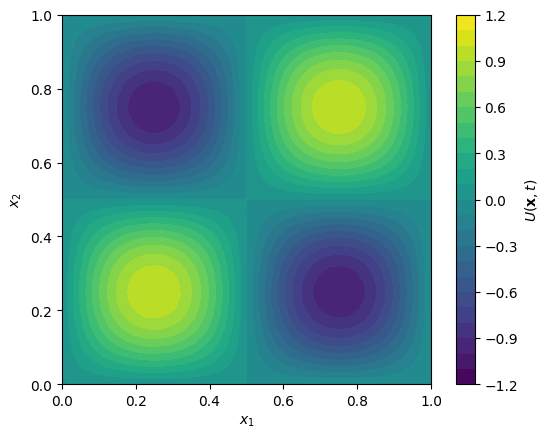

In [47]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

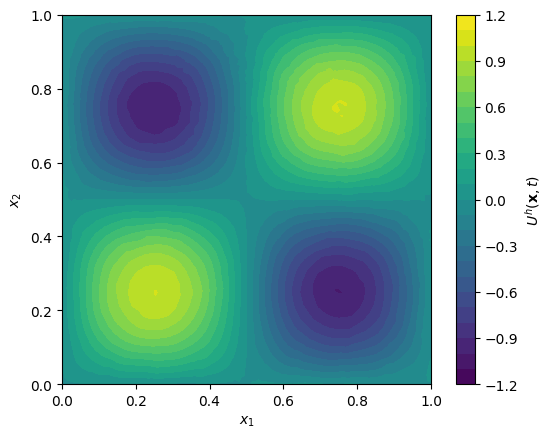

In [48]:
visualize(last(sol.u),plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [49]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.009001809306961924]
Conservation (initial/final/diff):
[-2.188741643190193e-7][-2.18874165719158e-7][-1.4001386855477804e-15]
Energy (initial/final/diff):
[0.24998649009990687][0.24998649009990762][7.494005416219807e-16]
